In [4]:
pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/332.0 MB 2.9 MB/s eta 0:01:53
   ---------------------------------------- 1.6/332.0 MB 2.9 MB/s eta 0:01:56
   ---------------------------------------- 2.1/332.0 MB 2.9 MB/s eta 0:01:54
   ---------------------------------------- 2.9/332.0 MB 3.0 MB/s eta 0:01:52
   ---------------------------------------- 3.4/332.0 MB 3.0 MB/s eta 0:01:51
   ---------------------------------------- 3.9/332.0 MB 2.9 MB/s eta 0:01:53
    --------------------------------------- 4.7/332.0 MB 2.9 MB/s eta 0:01:53
    --------------------------------------- 5.2/332.0 MB 2.9 MB/s eta 0:01:52
    --------------------------------------- 6.0/332.0 MB 2.9 MB/s eta 0:01:51
    --------------------------------------- 6.6/332.0 MB 3.0 MB/s eta 0:01:51
    --------------------------------------- 7.3/332.0 MB 3.0 MB/s eta 0:01:50


In [2]:
pip install scikeras


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.5 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.6 MB/s  0:00:00

   ------------- -------------------------- 2/6 [ml-dtypes]
   -------------------- ------------------- 3/6 [absl-py]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ------------- 4/6 [keras]
   -------------------------- ----

In [6]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("C:/Users/ADMIN/Downloads/TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [8]:

df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [11]:
df.columns = df.columns.str.strip()  # remove spaces
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [12]:
# Select only the close/adj close price
df = df[['Adj Close']].rename(columns={'Adj Close':'Close'})
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [13]:
#create sequences function
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

In [ ]:
#build train and test set for 1,5,10 days
# 1‑day window
X1, y1 = create_sequences(scaled_data, window=1)

# 5‑day
X5, y5 = create_sequences(scaled_data, window=5)

# 10‑day
X10, y10 = create_sequences(scaled_data, window=10)

def train_test_split(X, y, ratio=0.8):
    idx = int(len(X) * ratio)
    return X[:idx], X[idx:], y[:idx], y[idx:]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5)
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10)


In [16]:
def build_rnn(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(None,1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model

In [17]:
def build_lstm(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(None,1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model

In [18]:
param_grid = {
    "model__units": [50, 100],
    "model__dropout_rate": [0.2, 0.4],
    "optimizer__learning_rate": [1e-4, 1e-3],
    "fit__batch_size": [32, 64],
    "fit__epochs": [20, 40]
}

In [19]:
rnn_reg = KerasRegressor(
    model=build_rnn,
    callbacks=[EarlyStopping, ModelCheckpoint],
    callbacks__0__monitor="val_loss",          # First callback (EarlyStopping)
    callbacks__0__patience=5,
    callbacks__0__restore_best_weights=True,
    callbacks__1__filepath="best_rnn_model.h5", # Second callback (ModelCheckpoint)
    callbacks__1__monitor="val_loss",
    callbacks__1__save_best_only=True,
    fit__validation_split=0.2,
    verbose=0
)

In [20]:
grid_rnn1 = GridSearchCV(
    estimator=rnn_reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2
)

In [ ]:
grid_rnn1_result = grid_rnn1.fit(
    X1_train, y1_train)
print("Best SimpleRNN 1‑day:", grid_rnn1_result.best_params_)

In [22]:
best_rnn1 = grid_rnn1_result.best_estimator_
pred_rnn1 = best_rnn1.predict(X1_test)
pred_rnn1_inv = scaler.inverse_transform(pred_rnn1.reshape(-1,1))
true1_inv = scaler.inverse_transform(y1_test.reshape(-1,1))
print("RNN 1‑day MSE:", mean_squared_error(true1_inv, pred_rnn1_inv))

RNN 1‑day MSE: 161.85982451491944


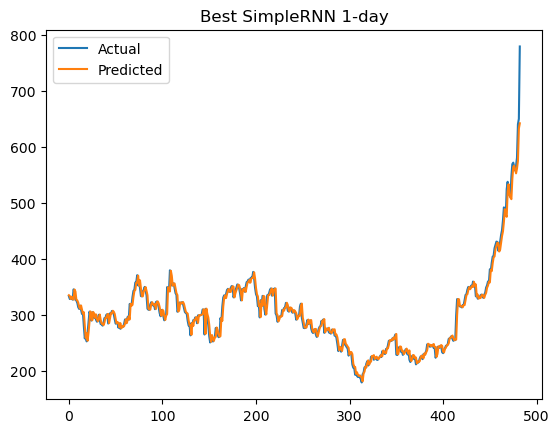

In [23]:
plt.plot(true1_inv, label="Actual")
plt.plot(pred_rnn1_inv, label="Predicted")
plt.title("Best SimpleRNN 1‑day")
plt.legend()
plt.show()

In [ ]:
grid_rnn5_result = GridSearchCV(rnn_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X5_train, y5_train)
print("Best SimpleRNN 5‑day:", grid_rnn5_result.best_params_)

In [25]:
best_rnn5 = grid_rnn5_result.best_estimator_
pred_rnn5 = best_rnn5.predict(X5_test)
pred_rnn5_inv = scaler.inverse_transform(pred_rnn5.reshape(-1,1))
true5_inv = scaler.inverse_transform(y5_test.reshape(-1,1))
print("RNN 5‑days MSE:", mean_squared_error(true5_inv, pred_rnn5_inv))

RNN 5‑days MSE: 285.4667834210586


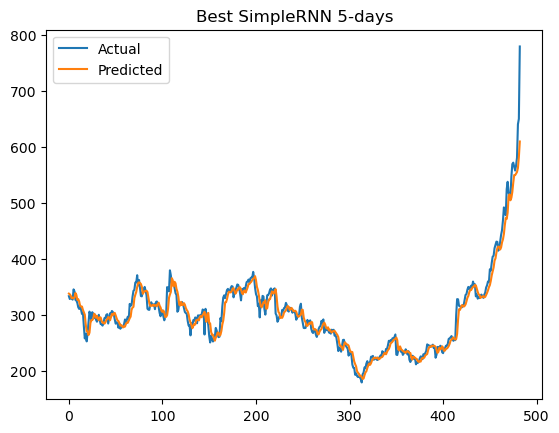

In [26]:
plt.plot(true5_inv, label="Actual")
plt.plot(pred_rnn5_inv, label="Predicted")
plt.title("Best SimpleRNN 5‑days")
plt.legend()
plt.show()

In [ ]:
grid_rnn10_result = GridSearchCV(rnn_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X10_train, y10_train)
print("Best SimpleRNN 10‑day:", grid_rnn10_result.best_params_)

In [28]:
best_rnn10 = grid_rnn10_result.best_estimator_
pred_rnn10 = best_rnn10.predict(X10_test)
pred_rnn10_inv = scaler.inverse_transform(pred_rnn10.reshape(-1,1))
true10_inv = scaler.inverse_transform(y10_test.reshape(-1,1))
print("RNN 10‑days MSE:", mean_squared_error(true10_inv, pred_rnn10_inv))

RNN 10‑days MSE: 542.3047667215446


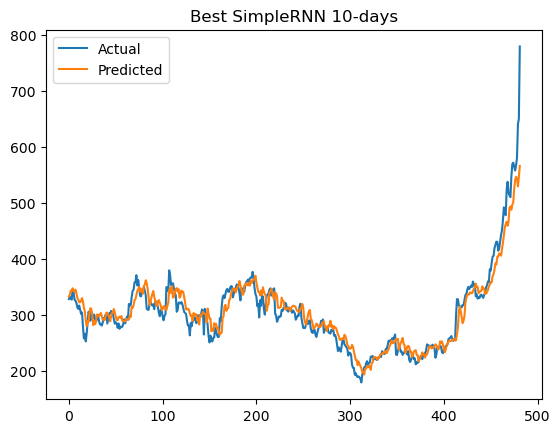

In [29]:
plt.plot(true10_inv, label="Actual")
plt.plot(pred_rnn10_inv, label="Predicted")
plt.title("Best SimpleRNN 10‑days")
plt.legend()
plt.show()

In [30]:
lstm_reg = KerasRegressor(
    model=build_lstm,
    
    # List of callback *classes* (SciKeras will instantiate them)
    callbacks=[EarlyStopping, ModelCheckpoint],
    
    # Configure the first callback (EarlyStopping)
    callbacks__0__monitor="val_loss",
    callbacks__0__patience=5,
    callbacks__0__restore_best_weights=True,
    
    # Configure the second callback (ModelCheckpoint)
    callbacks__1__filepath="best_lstm_model.h5",
    callbacks__1__monitor="val_loss",
    callbacks__1__save_best_only=True,
    
    # Validation split to allow val_loss monitoring
    fit__validation_split=0.2,
    
    verbose=0
)



In [ ]:
grid_lstm1_result = GridSearchCV(lstm_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X1_train, y1_train)
print("Best LSTM 1‑day:", grid_lstm1_result.best_params_)

In [32]:
best_lstm1 = grid_lstm1_result.best_estimator_
pred_lstm1 = best_lstm1.predict(X1_test)
pred_lstm1_inv = scaler.inverse_transform(pred_lstm1.reshape(-1,1))
actual1 = scaler.inverse_transform(y1_test.reshape(-1,1))

print("1‑day LSTM MSE:", mean_squared_error(actual1, pred_lstm1_inv))

1‑day LSTM MSE: 142.2329769801541


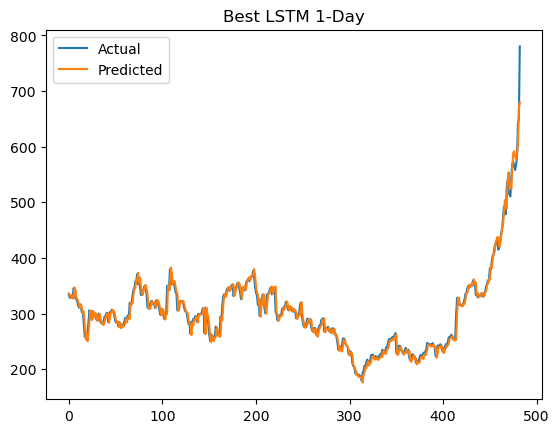

In [33]:
plt.plot(actual1, label="Actual")
plt.plot(pred_lstm1_inv, label="Predicted")
plt.legend()
plt.title("Best LSTM 1‑Day")
plt.show()

In [ ]:
grid_lstm5_result = GridSearchCV(lstm_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X5_train, y5_train)
print("Best LSTM 5‑day:", grid_lstm5_result.best_params_)

In [35]:
best_lstm5 = grid_lstm5_result.best_estimator_
pred_lstm5 = best_lstm5.predict(X5_test)
pred_lstm5_inv = scaler.inverse_transform(pred_lstm5.reshape(-1,1))
actual5 = scaler.inverse_transform(y5_test.reshape(-1,1))

print("5‑days LSTM MSE:", mean_squared_error(actual5, pred_lstm5_inv))

5‑days LSTM MSE: 345.0689011848372


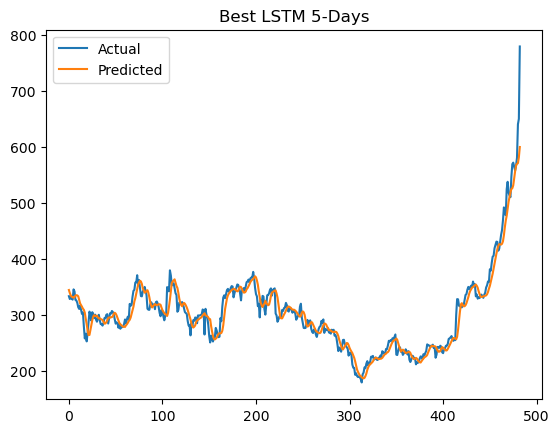

In [36]:
plt.plot(actual5, label="Actual")
plt.plot(pred_lstm5_inv, label="Predicted")
plt.legend()
plt.title("Best LSTM 5‑Days")
plt.show()

In [ ]:
grid_lstm10_result = GridSearchCV(lstm_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X10_train, y10_train)
print("Best LSTM 10‑day:", grid_lstm10_result.best_params_)

In [38]:
best_lstm10 = grid_lstm10_result.best_estimator_
pred_lstm10 = best_lstm10.predict(X10_test)
pred_lstm10_inv = scaler.inverse_transform(pred_lstm10.reshape(-1,1))
actual10 = scaler.inverse_transform(y10_test.reshape(-1,1))

print("10‑day LSTM MSE:", mean_squared_error(actual10, pred_lstm10_inv))

10‑day LSTM MSE: 437.36112214626104


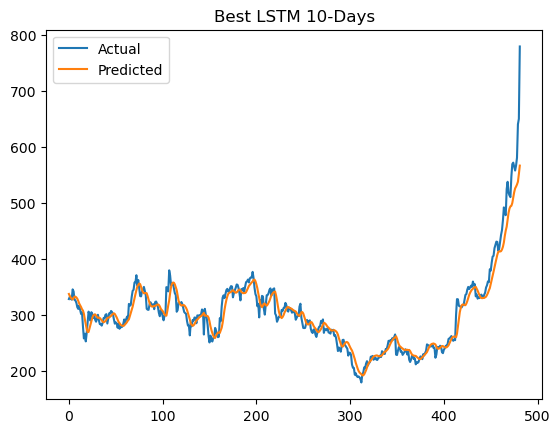

In [39]:
plt.plot(actual10, label="Actual")
plt.plot(pred_lstm10_inv, label="Predicted")
plt.legend()
plt.title("Best LSTM 10‑Days")
plt.show()